In [1]:
import gymnasium as gym
import stable_baselines3 as sb3
import pprint
import matplotlib.pyplot as plt
import cv2
import acc
%matplotlib inline

/home/s2908217/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Initialized: ego at 29.7, front at 77.7
Ego is behind front car by 48.0 units


/usr/lib/python3/dist-packages/gymnasium/utils/passive_env_checker.py:334: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


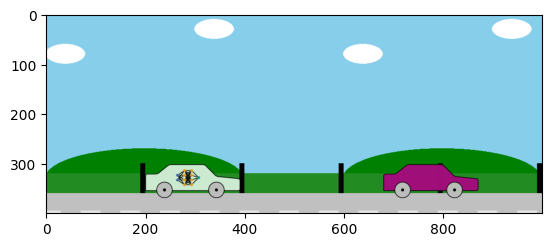

In [3]:
env = gym.make('acc-discrete-v0')
obs, info = env.reset()
frame = env.render()
plt.imshow(frame)

In [4]:
# Initialise model
# DQN for discrete actionS?
model = sb3.DQN(
    'MlpPolicy',
    env,
    policy_kwargs={'net_arch': [256,256]},
    learning_rate=5e-4,
    buffer_size=15000,
    learning_starts=1000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=500,
    verbose=0,
    tensorboard_log="car_control_dqn/"
)

In [5]:
def test_model(env, model, video=None, msg=None):
    obs, info = env.reset()
    frame = env.render()
    ep_len = 0
    ep_rew = 0

    while True:
        action, _ = model.predict(obs)

        # Perform action and update total reward
        obs, reward, terminated, truncated, info = env.step(action) # info contains {'crash': crash}
        ep_rew += reward

        # Record frame to video
        if video:
            frame = env.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_BAYER_BG2BGR)
            frame = cv2.putText(
                frame,
                msg,
                (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0,0,0),
                1,
                cv2.LINE_AA
            )
        video.write(frame)

    ep_len += 1

    if terminated or truncated:
        return ep_len, ep_rew

In [6]:
from tqdm import trange

NUM_ROUNDS = 30
NUM_TRAINING_STEPS_PER_ROUND = 5000
NUM_TESTS_PER_ROUND = 100
MODEL_FILENAME_BASE = "carcontrol-dqn"

FPS = 30
FOURCC = cv2.VideoWriter.fourcc('m', 'p', '4', 'v')
VIDEO_FILENAME = "training.mp4"
width = frame.shape[1]
height = frame.shape[0]
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

avg_ep_lens = []
avg_ep_rews = []
for rnd in trange(NUM_ROUNDS, desc="Training rounds"):
  model.learn(total_timesteps=NUM_TRAINING_STEPS_PER_ROUND) # train model
  model.save(f"{MODEL_FILENAME_BASE}_{rnd}")

  # Test the model in several episodes
  avg_ep_len = 0
  avg_ep_rew = 0
  for ep in trange(NUM_TESTS_PER_ROUND, desc=f"Testing round {rnd}", leave=False):
    # Only record the first test
    if ep == 0:
      ep_len, ep_rew = test_model(env, model, video, f"Round {rnd}")
    else:
      ep_len, ep_rew = test_model(env, model)

    # Accumulate avgs
    avg_ep_len += ep_len
    avg_ep_rew += ep_rew

  # Record and display avgs
  avg_ep_len /= NUM_TESTS_PER_ROUND
  avg_ep_lens.append(avg_ep_len)
  avg_ep_rew /= NUM_TESTS_PER_ROUND
  avg_ep_rews.append(avg_ep_rew)
  print(f"Round {rnd} | average test length: {avg_ep_len}, average test reward: {avg_ep_rew}")

# Close the video writer
video.release()


Training rounds:   0%|          | 0/30 [00:00<?, ?it/s]


Initialized: ego at 21.7, front at 89.2
Ego is behind front car by 67.5 units


ImportError: Trying to log data to tensorboard but tensorboard is not installed.

In [ ]:
# Plot average test episode lengths and rewards for each round
fig, axs = plt.subplots(1,2)
fig.tight_layout(pad=2.0)
axs[0].plot(avg_ep_lens)
axs[0].set_ylabel("Average episode length")
axs[0].set_xlabel("Round")
axs[1].plot(avg_ep_rews)
axs[1].set_ylabel("Average episode reward")
axs[1].set_xlabel("Round")